In [184]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [185]:
###### remove extraneous data from the CDC Excess Deaths data set and add the mid-point of excess deaths estimate ######

# Import CDC excess deaths data from file
xs_deaths = pd.read_csv("data/xs_deaths.csv")

# The CDC data has three entries for each state for each week. These represent whether they are Type "Predicted(weighted)" or "Unweighted" and Outcome "All causes"
# or "All causes, excluding COVID-19". For this analysis I onlly want the "Predicte(weighted)" and "All causes, excluding COVID-19". 
# Droping Type "All causes" solves that problem
xs_deaths.drop(xs_deaths[(xs_deaths['Outcome'] == 'All causes')].index , inplace=True)

# change the "date" to datetime type
xs_deaths['Week Ending Date'] =  pd.to_datetime(xs_deaths['Week Ending Date'])

#capture the lastest date of the CDC data - used later for getting avg of most recent excess deaths
latest_date_of_cdc_data = xs_deaths['Week Ending Date'].max()

# Drop PR and the "all US" data
indexNames = xs_deaths[ (xs_deaths['State'] == 'Puerto Rico') | 
                        (xs_deaths['State'] == 'United States')].index

xs_deaths.drop(indexNames , inplace=True) 

# Select only values that match the time period for the JHU data
xs_deaths_2020 = xs_deaths[(xs_deaths['Week Ending Date'] > '2020-01-21')].copy()
del xs_deaths

# drop the unnecessary columns 
xs_deaths_2020 = xs_deaths_2020.drop(xs_deaths_2020.columns[[2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16]], axis=1)

# add the average of the upper and lower xs deaths to the df
xs_deaths_2020['mid_point_xs_deaths'] = (xs_deaths_2020['Excess Lower Estimate'] + xs_deaths_2020['Excess Higher Estimate'])/2

# rename columns
xs_deaths_2020.rename(columns={"Week Ending Date": "date", "State":"state"}, inplace=True)

## merge the NYC city with the NY state data (CDC had the data broken out separately) ##
# merge the data
ny_data = xs_deaths_2020.loc[xs_deaths_2020['state'].str.contains('New York')].groupby('date').sum()

# Add a new 'state' column for merging back with the xs_deaths_2020 df
ny_data['state'] = 'New York'
ny_data.reset_index(inplace=True)

# change the order of the columns (probably delete this later)
ny_data = ny_data[['date', 'state', 'Excess Lower Estimate', 'Excess Higher Estimate', 'mid_point_xs_deaths']]

# drop the NY and NYC data from the xs_deaths_2020 df
xs_deaths_2020.drop(xs_deaths_2020[xs_deaths_2020['state'].str.contains('New York')].index , inplace=True)

# concatenate xs_death_2020 and ny_data so the df has all NY (NYC and NY state) data as NY state
dfs_to_concat = [xs_deaths_2020, ny_data]
xs_deaths_2020_ny = pd.concat(dfs_to_concat)
del xs_deaths_2020
del ny_data

# sort the data to be tidy :-)
xs_deaths_2020_ny.sort_values(by=['state','date'], inplace=True)
xs_deaths_2020_ny.reset_index(inplace=True)
del xs_deaths_2020_ny['index']

###### end/remove extraneous data from the CDC Excess Deaths data set ######




###### munge JHU data, remove extraneous data, and add 7-day rolling averages ######

# import data files
new_cases = pd.read_csv("data/jhu_confirmed_daily.csv")
new_deaths = pd.read_csv("data/jhu_deaths_daily.csv")

# drop the following columns because they aren't important to this analysis
new_cases.drop(["UID", "iso2", "iso3", "code3", "FIPS", "Country_Region", "Lat", "Long_", "Combined_Key"], axis=1, inplace=True)
new_deaths.drop(["UID", "iso2", "iso3", "code3", "FIPS", "Country_Region", "Lat", "Long_", "Combined_Key", "Population"], axis=1, inplace=True)

# melt into a long form instead of wide
new_cases_long = new_cases.melt(id_vars=["Admin2", "Province_State"], var_name="Date", value_name="New_Cases")
new_deaths_long = new_deaths.melt(id_vars=["Admin2", "Province_State"], var_name="Date", value_name="Deaths")
del new_cases
del new_deaths

# convert the date column from a string into datetime
new_cases_long['Date'] = pd.to_datetime(new_cases_long['Date'])
new_deaths_long['Date'] = pd.to_datetime(new_deaths_long['Date'])

## JHU data is at the county level - sum all the data from counties into state level ##
# groupby/sum - from https://jamesrledoux.com/code/group-by-aggregate-pandas
# output -> index, Province_State, Date, new_cases
new_cases_by_state = new_cases_long.groupby(['Province_State','Date']).agg({'New_Cases':['sum']})
del new_cases_long
new_cases_by_state.columns = ['new_cases']
new_cases_by_state = new_cases_by_state.reset_index()
new_cases_by_state.sort_values(['Province_State','Date'], inplace=True)

# output -> index, Province_State, Date, new_deaths
new_deaths_by_state = new_deaths_long.groupby(['Province_State','Date']).agg({'Deaths':['sum']})
del new_deaths_long
new_deaths_by_state.columns = ['new_deaths']
new_deaths_by_state = new_deaths_by_state.reset_index()
new_deaths_by_state.sort_values(['Province_State','Date'], inplace=True)

# replacing the administrative corrections that cause an artificial bump in NJ's deaths on 6/25/20
# https://kywnewsradio.radio.com/articles/news/new-jersey-now-reporting-probable-covid-19-deaths

new_deaths_by_state_fixed = new_deaths_by_state.copy()
del new_deaths_by_state

deaths_NJ_6_24 = new_deaths_by_state_fixed['new_deaths'].loc[(new_deaths_by_state_fixed['Province_State'] == 'New Jersey') & 
                                      (new_deaths_by_state_fixed['Date'] == '2020-06-24')].values[0]

deaths_NJ_6_25 = new_deaths_by_state_fixed['new_deaths'].loc[(new_deaths_by_state_fixed['Province_State'] == 'New Jersey') & 
                                      (new_deaths_by_state_fixed['Date'] == '2020-06-25')].values[0]

deaths_NJ_6_26 = new_deaths_by_state_fixed['new_deaths'].loc[(new_deaths_by_state_fixed['Province_State'] == 'New Jersey') & 
                                      (new_deaths_by_state_fixed['Date'] == '2020-06-26')].values[0]

substitution_value = ((deaths_NJ_6_24+deaths_NJ_6_26)/2)

new_deaths_by_state_fixed.loc[(new_deaths_by_state_fixed['Province_State'] == 'New Jersey') & 
                                      (new_deaths_by_state_fixed['Date'] == '2020-06-25'), 'new_deaths'] = substitution_value

del deaths_NJ_6_26

# add a column of a 7-day rolling average to daily cases and deaths
new_cases_by_state['new_cases_rollavg'] = (new_cases_by_state.groupby('Province_State')
                                                            .rolling(7)['new_cases']
                                                            .mean()
                                                            .reset_index(drop=True))

new_deaths_by_state_fixed['new_deaths_rollavg'] = (new_deaths_by_state_fixed.groupby('Province_State')
                                                                .rolling(7)['new_deaths']
                                                                .mean()
                                                                .reset_index(drop=True))

# Outer Join of the daily_cases and daily_deaths tables
combined_daily_cases_deaths = pd.merge(new_cases_by_state,new_deaths_by_state_fixed,on=['Province_State','Date'],how='outer')
del new_cases_by_state
del new_deaths_by_state_fixed

# drop Diamond Princess, Guam, American Somoa, Northern Mariana Islands, and Puerto Rico (other data sets don't have the territories)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "Diamond Princess"].index, inplace=True)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "Grand Princess"].index, inplace=True)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "American Samoa"].index, inplace=True)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "Guam"].index, inplace=True)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "Northern Mariana Islands"].index, inplace=True)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "Puerto Rico"].index, inplace=True)
combined_daily_cases_deaths.drop(combined_daily_cases_deaths.loc[combined_daily_cases_deaths['Province_State'] == "Virgin Islands"].index, inplace=True)

# save the processed data as a csv (for use by other applications such as the Streamlit webapp)
combined_daily_cases_deaths.to_csv("data/daily_cases_deaths.csv", index=False)

###### end/munge JHU data, remove extraneous data, and add 7-day rolling averages ######





###### create a table of the JHU data summed into weekly values instead of daily and merge with CDC excess deaths data ######

# drop the rolling averages, they're not necessary for the weekly sums data
daily_cases_deaths = combined_daily_cases_deaths.drop(combined_daily_cases_deaths.columns[[3, 5]], axis=1)
del combined_daily_cases_deaths

# rename columns because I prefer this convention
daily_cases_deaths.rename(columns={"Province_State": "state", "Date": "date", "new_cases": "new_cases_jhu", "new_deaths":"new_deaths_jhu"}, inplace=True)

# sum the weekly cases, match the week starting date to the one used by the CDC
weekly_cases_deaths = daily_cases_deaths.groupby('state').resample('W-SAT', on='date').sum()

# delete the lastest week if it's not a complete week
latest_date_of_jhu_data = daily_cases_deaths['date'].max()

# reset the index so 'date' is a column
weekly_cases_deaths.reset_index(inplace=True)

if latest_date_of_jhu_data.weekday() != 5:
    latest_date_of_weekly_cases_deaths = weekly_cases_deaths['date'].max()
    weekly_cases_deaths = weekly_cases_deaths[weekly_cases_deaths.date != latest_date_of_weekly_cases_deaths]

# free memory
del daily_cases_deaths

# merge the CDC weekly excess deaths with the JMU deaths data
weekly_cases_deaths_xs = pd.merge(weekly_cases_deaths, xs_deaths_2020_ny, how='left', left_on=['state','date'], right_on=['state','date']) 

###### end/group the JHU data into weekly values instead of daily ######

###### get the average of the last 4 values mid_point_xs_deaths

select_back_to = latest_date_of_cdc_data - timedelta(weeks=4) # this gives the date of the 5th week back

# select only the latest 4 weeks of data from the CDC excess deaths data
latest_weeks_xs_deaths = weekly_cases_deaths_xs[(weekly_cases_deaths_xs['date'] > select_back_to) & (weekly_cases_deaths_xs['date'] <= latest_date_of_cdc_data)].copy()

# average the latest 4 weeks data
latest_weeks_xs_deaths_avg = latest_weeks_xs_deaths.groupby('state').mean()

# convert the results to integers (rounds down)
latest_weeks_xs_deaths_avg = latest_weeks_xs_deaths_avg.astype(int)

# add the dates to indicate what date range the averages were taken from
latest_weeks_xs_deaths_avg['data_from_dates_after'] = select_back_to
latest_weeks_xs_deaths_avg['data_from_dates_up_to'] = latest_date_of_cdc_data

# reset the index
latest_weeks_xs_deaths_avg.reset_index(inplace=True)

###### end/get the average of the last 4 values mid_point_xs_deaths ######




###### calculating estimated actual deaths per day from CDC xs deaths and JHU reported deaths data ######

# create a dictionary of the mid_point_xs_deaths to make calculation quicker in the df
state_xs_deaths_dict = latest_weeks_xs_deaths_avg.set_index('state').to_dict()['mid_point_xs_deaths']

# function to calculate the reported + excess deaths - use value if exists for date, otherwise use 
# average of last 4 weeks of reported data

# the old version that didn't work well for states will low deaths
# def est_deaths(row):
#     if row['date'] <= latest_date_of_cdc_data:
#         corrected_value = row.fillna(0)['new_deaths_jhu'] + row.fillna(0)['mid_point_xs_deaths']
#     else:
#         corrected_value = row.fillna(0)['new_deaths_jhu'] + state_xs_deaths_dict[row['state']]
#     return corrected_value

# the new-improved version that doesn't estimate excess deaths for when a state has less than
# 6 deaths that week. Instead, it just uses the JHU reported deaths value and doesn't make a
# correction.
def est_deaths(row):
    if row['new_deaths_jhu'] < 6:
        corrected_value = row.fillna(0)['new_deaths_jhu']
    elif row['date'] <= latest_date_of_cdc_data:
        corrected_value = row.fillna(0)['new_deaths_jhu'] + row.fillna(0)['mid_point_xs_deaths']
    else:
        corrected_value = row.fillna(0)['new_deaths_jhu'] + state_xs_deaths_dict[row['state']]
    return corrected_value

# apply the calculation to each row
weekly_cases_deaths_xs['corr_new_deaths'] = weekly_cases_deaths_xs.apply(est_deaths, axis=1)

# save the data as a csv for the other modules
weekly_cases_deaths_xs.to_csv("data/weekly_cases_deaths_xs.csv", index=False)

###### end/calculating estimated actual deaths per day from CDC xs deaths and JHU reported deaths data ######




###### add the estimated infections that occured 2 weeks previous to the date of the corrected deaths ######

est_infections = weekly_cases_deaths_xs[['state', 'date','corr_new_deaths']].copy()

est_infections['offset_date'] = est_infections['date'] - timedelta(weeks=2)

# this is the inverse of the estimated infection fatality ratio - taken from literature
estimated_ifr = 200

est_infections['est_inf'] = est_infections['corr_new_deaths'] * estimated_ifr

# drop estimated infections before the start of the JHU dataset - not critical, just because
est_infections.drop(est_infections[est_infections['offset_date'] < '2020-01-22'].index , inplace=True)

# drop rows that were used to generate data but are not needed in the merge
est_infections.drop(['date', 'corr_new_deaths'], axis = 1, inplace=True) 

# merge the estimate infections back with weekly_cases_deaths_xs. This will result
# in nan values for the lastest two weeks. This method back-calculates the estimated 
# number of infections that had to have occured to cause the specified number of deaths,
# therefore the latest two weeks will have nan values. These values will be filled in 
# as time proceeds.
weekly_est_cases_deaths = weekly_cases_deaths_xs.merge(est_infections, 
                                                       left_on=['state','date'], 
                                                       right_on=['state','offset_date'],
                                                       how='outer')
                                    
# save as csv for use by other modules
weekly_est_cases_deaths.to_csv('data/weekly_est_cases_deaths.csv', index=False)

###### end/add the estimated infections that occured 2 weeks previous to the date of the corrected deaths ######

In [186]:
###### calculating the estimated proportion of the population that has already been infected with COVID-19 ######

# remove the last 2 weeks of data for each state because we don't have estimated infections for those dates
max_date_est_inf = weekly_est_cases_deaths['offset_date'].max()
trimed_last_2_wks = weekly_est_cases_deaths[(weekly_est_cases_deaths['date'] <= max_date_est_inf)]

sum_infections = trimed_last_2_wks.groupby('state')['est_inf','new_cases_jhu'].sum().astype('int32')

state_pop = pd.read_csv('data/state_pop.csv')

percent_pop_infected = state_pop.merge(sum_infections, left_on="NAME", right_on="state")
percent_pop_infected['est_proportion_infected'] = (percent_pop_infected['est_inf'] /
                                              percent_pop_infected['POPESTIMATE2019'])
percent_pop_infected['rep_proportion_infected'] = (percent_pop_infected['new_cases_jhu'] /
                                              percent_pop_infected['POPESTIMATE2019'])

percent_pop_infected.sort_values(by=['est_proportion_infected'], ascending=False, inplace=True)
percent_pop_infected.rename(columns={"NAME": "state", "POPESTIMATE2019": "2019_pop", "est_inf":"sum_est_inf", "new_cases_jhu":"sum_new_cases_jhu"}, inplace=True)

total_pop = percent_pop_infected['2019_pop'].sum()
total_infected = percent_pop_infected['sum_est_inf'].sum()
total_reported_infected = percent_pop_infected['sum_new_cases_jhu'].sum()

percent_total_us_pop_est_infected = f"{100*total_infected/total_pop:.1f}"
percent_total_us_pop_reported_infected = f"{100*total_reported_infected/total_pop:.1f}"

# from https://worldpopulationreview.com/states/state-abbreviations
state_abbrevs = pd.read_csv('data/state_abbrevs.csv')


def add_state_id(row):
    state = row['state']
    state_id = state_abbrevs[state_abbrevs['State'] == state]['Code']
    return state_id.values[0]
    
percent_pop_infected['state_id'] =  percent_pop_infected.apply(add_state_id, axis=1)

latest_date_of_estimate = str(max_date_est_inf)[:10]
date_of_reporting = str(latest_date_of_jhu_data)[:10]

print(f'Latest date of entry in JHU data {date_of_reporting}\n')
print('Estimated total percent of the US population that')
print(f'has been infected by COVID-19 as of {latest_date_of_estimate}:      '+str(percent_total_us_pop_est_infected)+'%\n')
print('Reported total percent of the US population that')
print(f'has been infected by COVID-19 as of {latest_date_of_estimate}:      '+str(percent_total_us_pop_reported_infected)+'%\n')
print(f'Propotion of population in all states that have been infected as of {latest_date_of_estimate} (reverse rank ordered)')
print('-----------------------------------------------------------------------------------------------------')
percent_pop_infected

###### end/calculating the estimated proportion of the population that has already been infected with COVID-19 ######

Latest date of entry in JHU data 2020-08-11

Estimated total percent of the US population that
has been infected by COVID-19 as of 2020-07-25:      12.9%

Reported total percent of the US population that
has been infected by COVID-19 as of 2020-07-25:      1.3%

Propotion of population in all states that have been infected as of 2020-07-25 (reverse rank ordered)
-----------------------------------------------------------------------------------------------------


,state,2019_pop,sum_est_inf,sum_new_cases_jhu,est_proportion_infected,rep_proportion_infected,state_id
30,New Jersey,8882190,3938600,178858,0.443427,0.020137,NJ
32,New York,19453561,8364800,411200,0.429988,0.021138,NY
6,Connecticut,3565287,1050000,48776,0.294506,0.013681,CT
21,Massachusetts,6892503,1870300,115268,0.271353,0.016724,MA
8,District of Columbia,705749,154800,11717,0.219341,0.016602,DC
18,Louisiana,4648794,1010000,103734,0.217261,0.022314,LA
39,Rhode Island,1059361,208500,18224,0.196817,0.017203,RI
22,Michigan,9986857,1958200,85622,0.196078,0.008573,MI
38,Pennsylvania,12801989,2434900,111115,0.190197,0.008680,PA
24,Mississippi,2976149,542300,50981,0.182215,0.017130,MS


In [187]:
weekly_est_cases_deaths.head(3)

,state,date,new_cases_jhu,new_deaths_jhu,Excess Lower Estimate,Excess Higher Estimate,mid_point_xs_deaths,corr_new_deaths,offset_date,est_inf
0,Alabama,2020-01-25,0,0.0,0.0,0.0,0.0,0.0,2020-01-25,0.0
1,Alabama,2020-02-01,0,0.0,0.0,0.0,0.0,0.0,2020-02-01,0.0
2,Alabama,2020-02-08,0,0.0,0.0,0.0,0.0,0.0,2020-02-08,0.0


In [188]:
###### estimating the population size of people infectious at specific dates ######
# in the original version of this analysis I was calculating total number of infections
# on a daily basis. In this version I switched to calculating infections on a weekly 
# basis to improve the statistical quality of the data. Previously I was calculating the 
# number of people who were in an infectious state by summing all the people infected 
# between 4 and 11 days prior to the day of interest. That won't work with this method
# since I'm summing up infections by week. I could still maintain a count of infections by 
# day but I don't think it would be that much of a change relative to just using the count
# of the people infected in the previous week as the number of people in an infectious 
# state - it should be a good enough approximation for a machine learning approach.

from math import isnan

# formula to sum up all the people who were infected between 4-10 days previous to the 
# current date being evaluated (literature estimate of avg infectious period is 7 days)
def infectious_count(row):
    offset_index = row.name - 1
    if row['state'] == weekly_est_cases_deaths.iloc[offset_index,0]:
        if isnan(weekly_est_cases_deaths.iloc[offset_index,9]):
            pass
        else:
            infectious_populace = weekly_est_cases_deaths.iloc[offset_index,9]
            return infectious_populace

weekly_est_cases_deaths["mobile_infectious"] = weekly_est_cases_deaths.apply(infectious_count, axis=1)

def proportion_infected(row):
    state = row['state']
    pop = percent_pop_infected[percent_pop_infected['state'] == state]['2019_pop']
    phi = row['mobile_infectious'] / pop.values[0]
    return phi

def population(row):
    state = row['state']
    pop = percent_pop_infected[percent_pop_infected['state'] == state]['2019_pop']
    return pop.values[0]

# these functions take a while to run because of the recursive iteration
weekly_est_cases_deaths["phi"] = weekly_est_cases_deaths.apply(proportion_infected, axis=1)
weekly_est_cases_deaths["population"] = weekly_est_cases_deaths.apply(population, axis=1)

###### end/estimating the population size of people infectious at specific dates ######

In [189]:
from scipy.stats import linregress

#Use of the free database in production requires that you link back to:
#https://simplemaps.com/data/us-cities

citimaps = pd.read_csv('data/simplemaps_uscities_basicv1.6/uscities.csv')

indexNames = citimaps[ (citimaps['state_id'] == 'US') | 
                      (citimaps['state_id'] == 'PR')].index

citimaps.drop(indexNames , inplace=True) 

state_density = citimaps.groupby('state_id')['population','density'].mean()
state_density.sort_values(by=['density'], inplace=True)

state_density.rename(columns={"population": "avg_city_pop", "density": "avg_city_density"}, inplace=True)

highest_density = state_density.nlargest(1, 'avg_city_density')

# rho is the normalized avg_city_density index
state_density['propotionate_density'] = state_density['avg_city_density'] / highest_density.values[0][1]
state_density.reset_index(level=0, inplace=True)

# Calculate the slope of the transform for density to normalized values between 0.5 and 1.
# I decided that the most dense state has BER = 1 while the least dense state has BER = 0.5.
# This compresses all the values between 0.5 for the lowest and 1.0 for the highest in the dataset
x1 = state_density.nsmallest(1, 'avg_city_density').values[0][3]
x2 = state_density.nlargest(1, 'avg_city_density').values[0][3]
y1 = 0.5
y2 = 1

slope, intercept, r_value, p_value, std_err = linregress([x1,x2],[y1,y2])

def rho_calc(row):
    rho = slope * row['propotionate_density'] + intercept
    return rho

state_density["rho"] = state_density.apply(rho_calc, axis=1)

def state_id(row):
    state = row['state']
    state_id = state_abbrevs[state_abbrevs['State'] == state]['Code']
    return state_id.values[0]

weekly_est_cases_deaths['state_id'] =  weekly_est_cases_deaths.apply(state_id, axis=1)

def add_rho(row):
    state = row['state_id']
    rho = state_density[state_density['state_id'] == state]['rho']
    return rho.values[0]

weekly_est_cases_deaths['rho'] =  weekly_est_cases_deaths.apply(add_rho, axis=1)

weekly_est_cases_deaths.head(5)

,state,date,new_cases_jhu,new_deaths_jhu,Excess Lower Estimate,Excess Higher Estimate,mid_point_xs_deaths,corr_new_deaths,offset_date,est_inf,mobile_infectious,phi,population,state_id,rho
0,Alabama,2020-01-25,0,0.0,0.0,0.0,0.0,0.0,2020-01-25,0.0,NaN,NaN,4903185,AL,0.51225
1,Alabama,2020-02-01,0,0.0,0.0,0.0,0.0,0.0,2020-02-01,0.0,0.0,0.0,4903185,AL,0.51225
2,Alabama,2020-02-08,0,0.0,0.0,0.0,0.0,0.0,2020-02-08,0.0,0.0,0.0,4903185,AL,0.51225
3,Alabama,2020-02-15,0,0.0,0.0,0.0,0.0,0.0,2020-02-15,0.0,0.0,0.0,4903185,AL,0.51225
4,Alabama,2020-02-22,0,0.0,0.0,1.0,0.5,0.0,2020-02-22,0.0,0.0,0.0,4903185,AL,0.51225


In [190]:
mobility_data = pd.read_csv("data/Global_Mobility_Report.csv")

# drop non-US data
mobility_data.drop(mobility_data.loc[mobility_data['country_region_code'] != "US"].index, inplace=True)

# drop county data, only using state level data for this analysis
mobility_data = mobility_data[mobility_data['sub_region_2'].isna()]

# drop other unnecessary columns
mobility_data.drop(['country_region_code','country_region','iso_3166_2_code','census_fips_code','metro_area','sub_region_2'], axis=1, inplace=True)

# convert date column to datetime formate
mobility_data['date'] = pd.to_datetime(mobility_data['date'])

# there are values that are "US" but don't have a sub_region_1 - they're probably all US - drop these
mobility_data.dropna(subset=['sub_region_1'], inplace=True)

mobility_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9027 entries, 1287696 to 1753534
Data columns (total 8 columns):
sub_region_1                                          9027 non-null object
date                                                  9027 non-null datetime64[ns]
retail_and_recreation_percent_change_from_baseline    9027 non-null float64
grocery_and_pharmacy_percent_change_from_baseline     9027 non-null float64
parks_percent_change_from_baseline                    8961 non-null float64
transit_stations_percent_change_from_baseline         9027 non-null float64
workplaces_percent_change_from_baseline               9027 non-null float64
residential_percent_change_from_baseline              9027 non-null float64
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 634.7+ KB


In [191]:
mobility_data.head(1)

,sub_region_1,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
1287696,Alabama,2020-02-15,5.0,2.0,39.0,7.0,2.0,-1.0


In [192]:
mob_data_for_plotting = mobility_data.iloc[:,0:8]

mob_data_for_plotting.rename(columns={'retail_and_recreation_percent_change_from_baseline':'retail_pcfb',
                     'grocery_and_pharmacy_percent_change_from_baseline':'groc_pcfb',
                     'parks_percent_change_from_baseline':'parks_pcfb',
                     'transit_stations_percent_change_from_baseline':'transit_pcfb',
                     'workplaces_percent_change_from_baseline':'work_pcfb',
                     'residential_percent_change_from_baseline':'res_pcfb'}, inplace=True)

mob_data_for_plotting.head(1)

,sub_region_1,date,retail_pcfb,groc_pcfb,parks_pcfb,transit_pcfb,work_pcfb,res_pcfb
1287696,Alabama,2020-02-15,5.0,2.0,39.0,7.0,2.0,-1.0


In [193]:
# count the number of nan values in the mobility data
count_nan_mob_data_for_plotting = pd.DataFrame(mob_data_for_plotting[['retail_pcfb',
              'groc_pcfb',
              'parks_pcfb',
              'transit_pcfb',
              'work_pcfb',
              'res_pcfb']
             ].isnull().groupby(mob_data_for_plotting['sub_region_1']).sum())

# get rid of the decimals by converting to int
count_nan_mob_data_for_plotting = count_nan_mob_data_for_plotting.iloc[:,0:6].astype(dtype='int32')

# capture all records with any nan into a new df for display
count_of_nan = count_nan_mob_data_for_plotting[(count_nan_mob_data_for_plotting.iloc[:,0] != 0) | 
            (count_nan_mob_data_for_plotting.iloc[:,1] != 0) |
            (count_nan_mob_data_for_plotting.iloc[:,2] != 0) |
            (count_nan_mob_data_for_plotting.iloc[:,3] != 0) |
            (count_nan_mob_data_for_plotting.iloc[:,4] != 0) |
            (count_nan_mob_data_for_plotting.iloc[:,5] != 0)]

count_days_data = mob_data_for_plotting['date'].nunique()
print(f'Number of days of missing data in each activity bin by state out of {count_days_data} days of data')
count_of_nan

Number of days of missing data in each activity bin by state out of 177 days of data


,retail_pcfb,groc_pcfb,parks_pcfb,transit_pcfb,work_pcfb,res_pcfb
sub_region_1,,,,,,
Alaska,0,0,1,0,0,0
Delaware,0,0,25,0,0,0
Idaho,0,0,18,0,0,0
North Dakota,0,0,10,0,0,0
Rhode Island,0,0,2,0,0,0
South Dakota,0,0,1,0,0,0
Vermont,0,0,1,0,0,0
Wyoming,0,0,8,0,0,0


In [194]:
# show the records with nan values. In general, the missing data by state are not sequential but distributed 
# throughout the range of dates as shown below. This is rationalization for filling by interpolating from 
# the prior and following values.
mob_data_for_plotting_test = mob_data_for_plotting[mob_data_for_plotting.isna().any(axis=1)]
mob_data_for_plotting_test.head(60)

,sub_region_1,date,retail_pcfb,groc_pcfb,parks_pcfb,transit_pcfb,work_pcfb,res_pcfb
1299403,Alaska,2020-07-30,13.0,17.0,NaN,3.0,-29.0,5.0
1335227,Delaware,2020-04-25,-37.0,-16.0,NaN,-37.0,-30.0,11.0
1335234,Delaware,2020-05-02,-32.0,-11.0,NaN,-26.0,-28.0,10.0
1335241,Delaware,2020-05-09,-31.0,0.0,NaN,-37.0,-25.0,11.0
1335248,Delaware,2020-05-16,-29.0,-7.0,NaN,-28.0,-23.0,8.0
1335255,Delaware,2020-05-23,-28.0,-4.0,NaN,-30.0,-19.0,9.0
1335262,Delaware,2020-05-30,-25.0,-3.0,NaN,-15.0,-12.0,7.0
1335268,Delaware,2020-06-05,-16.0,-2.0,NaN,-32.0,-37.0,14.0
1335269,Delaware,2020-06-06,-12.0,5.0,NaN,-20.0,-10.0,5.0
1335275,Delaware,2020-06-12,-8.0,3.0,NaN,-24.0,-35.0,11.0


In [195]:
# fill nan by interpolation
mobility_data.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)

# show how well the interpolation did in filling the nan values - drop this when integrating into moduleHi John
mob_data_for_plotting = mobility_data.iloc[:,0:8]

mob_data_for_plotting.rename(columns={'retail_and_recreation_percent_change_from_baseline':'retail_pcfb',
                     'grocery_and_pharmacy_percent_change_from_baseline':'groc_pcfb',
                     'parks_percent_change_from_baseline':'parks_pcfb',
                     'transit_stations_percent_change_from_baseline':'transit_pcfb',
                     'workplaces_percent_change_from_baseline':'work_pcfb',
                     'residential_percent_change_from_baseline':'res_pcfb'}, inplace=True)

mob_data_for_plotting_test = mob_data_for_plotting[mob_data_for_plotting.isna().any(axis=1)]
mob_data_for_plotting_test.head()

,sub_region_1,date,retail_pcfb,groc_pcfb,parks_pcfb,transit_pcfb,work_pcfb,res_pcfb


In [196]:
# List of state to use in the loop to process the data for each state
list_of_states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', \
                  'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', \
                  'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', \
                  'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', \
                  'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', \
                  'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

#create an empty df to receive the processed data
df_columns = [
 'sub_region_1',
 'date',
 'retail_and_recreation_percent_change_from_baseline',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'parks_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'residential_percent_change_from_baseline',
 'retail_and_recreation_percent_change_from_baseline_rolling_avg',
 'grocery_and_pharmacy_percent_change_from_baseline_rolling_avg',
 'parks_percent_change_from_baseline_rolling_avg',
 'transit_stations_percent_change_from_baseline_rolling_avg',
 'workplaces_percent_change_from_baseline_rolling_avg',
 'residential_percent_change_from_baseline_rolling_avg',
 'retail_n_rec_normal_exp_per_day',
 'groc_n_pharm_normal_exp_per_day',
 'parks_normal_exp_per_day',
 'trans_stat_normal_exp_per_day',
 'work_normal_exp_per_day',
 'res_normal_exp_per_day',
 'normal_exposure_per_day',]
all_state_mob_data = pd.DataFrame(columns = df_columns)
all_state_mob_data['date'] = pd.to_datetime(all_state_mob_data['date'])

# loop through the data to process the data for each state
for state_selected in list_of_states:
    
    # subselect state data
    state_mob_data = mobility_data.drop(mobility_data.loc[mobility_data['sub_region_1'] \
                                         != state_selected].index)
        
    # subselect just the data from the state that doesn't have a county listed 
    #state_mobility_data = state_mob_data[state_mob_data['sub_region_2'].isna()]
    
    # create an explicit copy of the dataframe to avoid the "A value is trying to be set on a copy of a slice from 
    # a DataFrame." Pandas warning
    state_mobility_data = state_mob_data.copy()
    
    # calculate a rolling 7-day average for the 'precent change columns'
    column_titles = ['retail_and_recreation_percent_change_from_baseline', \
                    'grocery_and_pharmacy_percent_change_from_baseline', \
                    'parks_percent_change_from_baseline', \
                    'transit_stations_percent_change_from_baseline', \
                    'workplaces_percent_change_from_baseline', \
                    'residential_percent_change_from_baseline']
    for cat_item in column_titles:
        column_title = cat_item + '_rolling_avg'
        state_mobility_data[column_title] = \
        state_mobility_data[cat_item].rolling(window=7, center=False).mean()
        
    # the values in the embedded lists in the dictionary are "column titles" of the locations istn state_mobility_data, 
    # baseline hours spent in those locations, exposure rates in those locations under "normal" conditions,
    # exposure rates in those locations under "strict" social distancing conditions, and exposure rates in those 
    # locations under "relaxed" social distancing conditions
   
    column_name_dict = {
            "retail_n_rec": ['retail_and_recreation_percent_change_from_baseline', 1, 50], 
            "groc_n_pharm": ['grocery_and_pharmacy_percent_change_from_baseline', 1, 100],
            "parks": ['parks_percent_change_from_baseline', 0.25, 10],
            "trans_stat": ['transit_stations_percent_change_from_baseline', 0.25, 20],
            "work": ['workplaces_percent_change_from_baseline', 8.75, 20],
            "res": ['residential_percent_change_from_baseline', 12.75, 1]
            }
    
    # calculate the daily exposure for the average person in each 'location' bucket under "normal" conditions
    for item in column_name_dict:
        new_column_title = item + '_normal_exp_per_day'
        mobility_column = column_name_dict[item][0]
        baseline_hours = column_name_dict[item][1]
        exposure_rate = column_name_dict[item][2]
   
        # The hours that the individual spends goes up or down by the percentage change indicated by the mobility index. 
        # The exposure rate also changes by the same proportion because there are commesurately more or less people in
        # the space, thus increasing or decreasing the exposure rate
        state_mobility_data[new_column_title] = \
        ((state_mobility_data[mobility_column]/100 * baseline_hours) + baseline_hours) * \
        (exposure_rate * (1 + state_mobility_data[mobility_column]/100))
    
    # sum the exposure buckets for "normal" conditions
    sum_column = state_mobility_data['retail_n_rec_normal_exp_per_day'] + state_mobility_data['groc_n_pharm_normal_exp_per_day'] + \
    state_mobility_data['parks_normal_exp_per_day'] + state_mobility_data['trans_stat_normal_exp_per_day'] + \
    state_mobility_data['work_normal_exp_per_day'] + state_mobility_data['res_normal_exp_per_day']

    state_mobility_data['normal_exposure_per_day'] = sum_column
    
    all_state_mob_data = all_state_mob_data.append(state_mobility_data, ignore_index = True)
    
    # drop intermediate dfs each loop
    del state_mob_data
    del state_mobility_data
    
    # Need the spaces to overwrite characters from longer names when followed by shorter names
    print('Finished', state_selected,'                         ', end='\r')

print('All Done!                                    ', end='\r')
#all_state_mob_data.drop('sub_region_2', axis=1, inplace=True)

# write the data out in case it's useful for something else
all_state_mob_data.to_csv("data/all_state_mob_data.csv", index=False)

# extracting latest date of GMD data for informing the viewer how current the data is
latest_date_of_GMD = all_state_mob_data.nlargest(1, 'date')
most_recent_GMD_data = str(latest_date_of_GMD.values[0][0])[:10]

# drop extraneous columns
for_weekly_mob_calc = all_state_mob_data.drop(["groc_n_pharm_normal_exp_per_day", 
                                 "grocery_and_pharmacy_percent_change_from_baseline",
                                 "grocery_and_pharmacy_percent_change_from_baseline_rolling_avg", 
                                 "parks_normal_exp_per_day", 
                                 "parks_percent_change_from_baseline", 
                                 "parks_percent_change_from_baseline_rolling_avg", 
                                 "res_normal_exp_per_day", 
                                 "retail_and_recreation_percent_change_from_baseline",
                                 "retail_and_recreation_percent_change_from_baseline_rolling_avg",
                                 "retail_n_rec_normal_exp_per_day",
                                 "trans_stat_normal_exp_per_day",
                                 "transit_stations_percent_change_from_baseline",
                                 "transit_stations_percent_change_from_baseline_rolling_avg",
                                 "work_normal_exp_per_day",
                                 "workplaces_percent_change_from_baseline",
                                 "workplaces_percent_change_from_baseline_rolling_avg",
                                 "residential_percent_change_from_baseline",
                                 "residential_percent_change_from_baseline_rolling_avg"], axis=1)

for_weekly_mob_calc['date'] =  pd.to_datetime(for_weekly_mob_calc['date'])

# for_weekly_mob_calc.set_index('date', inplace=True)

# sum the weekly cases, match the week starting date to the one used by the CDC
weekly_mobility_data = for_weekly_mob_calc.groupby('sub_region_1').resample('W-SAT', on='date').mean()

latest_date_of_GMD = for_weekly_mob_calc['date'].max()

weekly_mobility_data.reset_index(inplace=True)

# delete the lastest week if it's not a complete week
if latest_date_of_GMD.weekday() != 5:
    latest_date_of_weekly_mob_data = weekly_mobility_data.date.max()
    weekly_mobility_data = weekly_mobility_data[weekly_mobility_data.date != latest_date_of_weekly_mob_data]
    
weekly_mobility_data.iloc[23:27,] 

,sub_region_1,date,normal_exposure_per_day
23,Alabama,2020-07-25,264.230232
24,Alabama,2020-08-01,265.848850
25,Alabama,2020-08-08,273.853993
27,Alaska,2020-02-15,360.933500


In [197]:
# merge the normal_exposure_per_day data into the weekly_est_cases_deaths df
weekly_est_cases_deaths = weekly_est_cases_deaths.merge(weekly_mobility_data, left_on=['state','date'], right_on=['sub_region_1','date'], how='outer') 
del weekly_est_cases_deaths['sub_region_1']
weekly_est_cases_deaths.drop(weekly_est_cases_deaths[weekly_est_cases_deaths['date'] <= '2020-02-08' ].index, inplace=True)


In [198]:
weekly_est_cases_deaths.head(1)

,state,date,new_cases_jhu,new_deaths_jhu,Excess Lower Estimate,Excess Higher Estimate,mid_point_xs_deaths,corr_new_deaths,offset_date,est_inf,mobile_infectious,phi,population,state_id,rho,normal_exposure_per_day
3,Alabama,2020-02-15,0,0.0,0.0,0.0,0.0,0.0,2020-02-15,0.0,0.0,0.0,4903185,AL,0.51225,364.286025


In [199]:
prob_actual_exposure_to_disease = 0.01

def add_psi(row):
    if ((row['normal_exposure_per_day'] == 0) or (row['mobile_infectious'] == 0) or 
        (row['rho'] == 0) or (row['est_inf'] == 0)):
        return np.nan
    else:
        psi = (row['est_inf']/(row['normal_exposure_per_day'] * row['mobile_infectious'] * row['rho'] * prob_actual_exposure_to_disease))
        return psi

weekly_est_cases_deaths["psi"] = weekly_est_cases_deaths.apply(add_psi, axis=1)
weekly_est_cases_deaths.head(3)

,state,date,new_cases_jhu,new_deaths_jhu,Excess Lower Estimate,Excess Higher Estimate,mid_point_xs_deaths,corr_new_deaths,offset_date,est_inf,mobile_infectious,phi,population,state_id,rho,normal_exposure_per_day,psi
3,Alabama,2020-02-15,0,0.0,0.0,0.0,0.0,0.0,2020-02-15,0.0,0.0,0.0,4903185,AL,0.51225,364.286025,NaN
4,Alabama,2020-02-22,0,0.0,0.0,1.0,0.5,0.0,2020-02-22,0.0,0.0,0.0,4903185,AL,0.51225,341.847146,NaN
5,Alabama,2020-02-29,0,0.0,1.0,74.0,37.5,0.0,2020-02-29,0.0,0.0,0.0,4903185,AL,0.51225,369.181343,NaN


In [200]:
all_data = weekly_est_cases_deaths.copy()

df_corr = all_data[(all_data['state'] == 'Arizona')]

corr_matrix = all_data[['est_inf', 'phi', 'rho', 'normal_exposure_per_day','mobile_infectious']]

corr_matrix.corr(method = 'spearman')

,est_inf,phi,rho,normal_exposure_per_day,mobile_infectious
est_inf,1.000000,0.823751,0.305746,-0.571725,0.950926
phi,0.823751,1.000000,0.204962,-0.611527,0.901327
rho,0.305746,0.204962,1.000000,-0.301736,0.284252
normal_exposure_per_day,-0.571725,-0.611527,-0.301736,1.000000,-0.617576
mobile_infectious,0.950926,0.901327,0.284252,-0.617576,1.000000


In [201]:
# def get_slope(array):
#     y = np.array(array)
#     x = np.arange(len(y))
#     slope, intercept, r_value, p_value, std_err = linregress(x,y)
#     return slope

# days_back = 21

# weekly_est_cases_deaths['slope_recent_weeks'] = weekly_est_cases_deaths.groupby('State')['est_inf'].rolling(window=days_back,
#                                min_periods=days_back).apply(get_slope, raw=False).reset_index(0, drop=True)

# # calculates the change in slope over the last 21 days (getting better or worse/2nd derivative)

# days_back = 21

# all_data['2nd_deriv'] = all_data.groupby('State')['rolling_slope'].rolling(window=days_back,
#                                min_periods=days_back).apply(get_slope, raw=False).reset_index(0, drop=True)

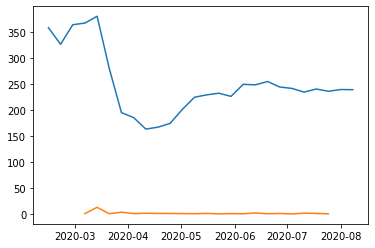

In [202]:
for_plotting = all_data[all_data['state'] == 'Georgia']
for_plotting2 = all_data[all_data['state'] == 'Virginia']
plt.plot('date', 'normal_exposure_per_day', data = for_plotting)
plt.plot('date', 'psi', data = for_plotting2)
plt.show()

In [203]:
for_plotting.head(1)

,state,date,new_cases_jhu,new_deaths_jhu,Excess Lower Estimate,Excess Higher Estimate,mid_point_xs_deaths,corr_new_deaths,offset_date,est_inf,mobile_infectious,phi,population,state_id,rho,normal_exposure_per_day,psi
293,Georgia,2020-02-15,0,0.0,0.0,13.0,6.5,0.0,2020-02-15,0.0,0.0,0.0,10617423,GA,0.531901,358.597775,NaN


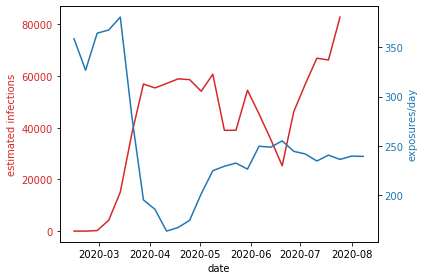

In [204]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('estimated infections', color=color)
ax1.plot(for_plotting['date'], for_plotting['est_inf'], color=color)
#ax1.plot(for_plotting['date'], for_plotting['new_cases_jhu'], label = "line 2")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('exposures/day', color=color)  
ax2.plot(for_plotting['date'], for_plotting['normal_exposure_per_day'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# ax3 = ax1.twinx()  

# color = 'tab:green'
# ax3.set_ylabel('deaths/day', color=color)  
# ax3.plot(for_plotting['date'], for_plotting['psi'], color=color)
# ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

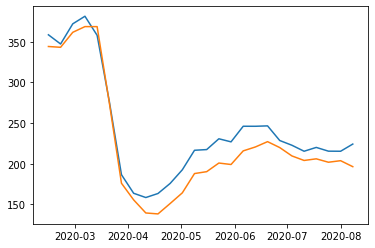

In [205]:
for_plotting = weekly_mobility_data[weekly_mobility_data['sub_region_1'] == 'Texas']
for_plotting2 = weekly_mobility_data[weekly_mobility_data['sub_region_1'] == 'Florida']

plt.plot('date', 'normal_exposure_per_day', data = for_plotting)
plt.plot('date', 'normal_exposure_per_day', data = for_plotting2)
plt.show()

In [206]:
all_data.head(3)

,state,date,new_cases_jhu,new_deaths_jhu,Excess Lower Estimate,Excess Higher Estimate,mid_point_xs_deaths,corr_new_deaths,offset_date,est_inf,mobile_infectious,phi,population,state_id,rho,normal_exposure_per_day,psi
3,Alabama,2020-02-15,0,0.0,0.0,0.0,0.0,0.0,2020-02-15,0.0,0.0,0.0,4903185,AL,0.51225,364.286025,NaN
4,Alabama,2020-02-22,0,0.0,0.0,1.0,0.5,0.0,2020-02-22,0.0,0.0,0.0,4903185,AL,0.51225,341.847146,NaN
5,Alabama,2020-02-29,0,0.0,1.0,74.0,37.5,0.0,2020-02-29,0.0,0.0,0.0,4903185,AL,0.51225,369.181343,NaN


In [207]:

# normal_exposures_per_day = all_state_mob_data[['date','sub_region_1','normal_exposure_per_day']]

# all_data.merge(normal_exposures_per_day, left_on=['date','state'], 
#                                                    right_on=['date','sub_region_1'], how='left')

In [208]:
mob_data_for_plotting = all_state_mob_data.iloc[:,0:8]

mob_data_for_plotting.rename(columns={'retail_and_recreation_percent_change_from_baseline':'retail_pcfb',
                     'grocery_and_pharmacy_percent_change_from_baseline':'groc_pcfb',
                     'parks_percent_change_from_baseline':'parks_pcfb',
                     'transit_stations_percent_change_from_baseline':'transit_pcfb',
                     'workplaces_percent_change_from_baseline':'work_pcfb',
                     'residential_percent_change_from_baseline':'res_pcfb'}, inplace=True)

mob_data_for_plotting.head(5)

,sub_region_1,date,retail_pcfb,groc_pcfb,parks_pcfb,transit_pcfb,work_pcfb,res_pcfb
0,Alabama,2020-02-15,5.0,2.0,39.0,7.0,2.0,-1.0
1,Alabama,2020-02-16,0.0,-2.0,-7.0,3.0,-1.0,1.0
2,Alabama,2020-02-17,3.0,0.0,17.0,7.0,-17.0,4.0
3,Alabama,2020-02-18,-4.0,-3.0,-11.0,-1.0,1.0,2.0
4,Alabama,2020-02-19,4.0,1.0,6.0,4.0,1.0,0.0


In [209]:
mob_data_for_plotting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9027 entries, 0 to 9026
Data columns (total 8 columns):
sub_region_1    9027 non-null object
date            9027 non-null datetime64[ns]
retail_pcfb     9027 non-null float64
groc_pcfb       9027 non-null float64
parks_pcfb      9027 non-null float64
transit_pcfb    9027 non-null float64
work_pcfb       9027 non-null float64
res_pcfb        9027 non-null float64
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 564.3+ KB


In [210]:
count_nan_mob_data_for_plotting = pd.DataFrame(mob_data_for_plotting[['retail_pcfb',
              'groc_pcfb',
              'parks_pcfb',
              'transit_pcfb',
              'work_pcfb',
              'res_pcfb']
             ].isnull().groupby(mob_data_for_plotting['sub_region_1']).sum())

count_nan_mob_data_for_plotting = count_nan_mob_data_for_plotting.iloc[:,0:6].astype(dtype='int32')

In [211]:
count_of_nan = count_nan_mob_data_for_plotting[(count_nan_mob_data_for_plotting.iloc[:,0] != 0) | 
            (count_nan_mob_data_for_plotting.iloc[:,1] != 0) |
            (count_nan_mob_data_for_plotting.iloc[:,2] != 0) |
            (count_nan_mob_data_for_plotting.iloc[:,3] != 0) |
            (count_nan_mob_data_for_plotting.iloc[:,4] != 0) |
            (count_nan_mob_data_for_plotting.iloc[:,5] != 0)]

count_days_data = mob_data_for_plotting['date'].nunique()

print(f'Number of days of missing data in each activity bin by state out of {count_days_data} days of data')
count_of_nan

Number of days of missing data in each activity bin by state out of 177 days of data


,retail_pcfb,groc_pcfb,parks_pcfb,transit_pcfb,work_pcfb,res_pcfb
sub_region_1,,,,,,


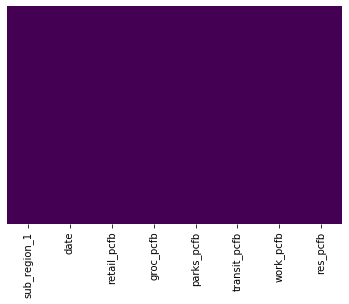

In [212]:
sns.heatmap(mob_data_for_plotting.isnull(), 
    yticklabels=False, 
    xticklabels=True,
    cbar=False, 
    cmap='viridis')

In [213]:
#for_plotting = all_state_mob_data[all_state_mob_data['sub_region_1'] == 'Alaska']
#for_plotting2 = all_state_mob_data[all_state_mob_data['sub_region_1'] == 'Idaho']
# plt.plot('date', 'normal_exposure_per_day', data = for_vis)
plt.plot('date', 'parks_percent_change_from_baseline', data = for_vis)
plt.plot('date', 'retail_and_recreation_percent_change_from_baseline', data = for_vis)
plt.show()

NameError: name 'for_vis' is not defined